# Insert SOILGRIDS-derived soil class in SUMMA set up
Inserts mode soil class of each HRU into the attributes `.nc` file. The intersection code stores a histogram of soil classes in fields `USGS_{0,1,...,12}`.

In [1]:
# modules
import os
os.chdir('/home/dlhogan/GitHub/mtn_hydro_pysumma')
import numpy as np
import netCDF4 as nc4
import geopandas as gpd
from pathlib import Path
from shutil import copyfile
from datetime import datetime
from utils.read_files import read_from_control, make_default_path

#### Control file handling

In [2]:
# Store the name of the 'active' file in a variable
basin = "EastRiver"
controlFile = f'control_{basin}.txt'
averaging_type = 'majority'

#### Find shapefile location and name

In [3]:
# Path to and name of shapefile with intersection between catchment and soil classes
intersect_path = read_from_control(controlFile,'intersect_soil_path')
intersect_name = read_from_control(controlFile,'intersect_soil_name')

In [4]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_soilgrids', controlFile) # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

In [5]:
# Variable names used in shapefile
intersect_hruId_var = read_from_control(controlFile,'catchment_shp_hruid')

#### Find where the attributes file is

In [6]:
# Attribute path & name
attribute_path = read_from_control(controlFile,'settings_summa_path')
attribute_name = read_from_control(controlFile,'settings_summa_attributes')

In [7]:
# Specify default path if needed
if attribute_path == 'default':
    attribute_path = make_default_path('settings/SUMMA', controlFile) # outputs a Path()
else:
    attribute_path = Path(attribute_path) # make sure a user-specified path is a Path()

#### Open the files and fill the placeholder values in the attributes file

In [8]:
# Open files
shp = gpd.read_file(intersect_path/intersect_name)

In [10]:
if averaging_type == 'histogram':
    # Open the netcdf file for reading+writing
    with nc4.Dataset(attribute_path/attribute_name, "r+") as att:
        
        # Loop over the HRUs in the attributes
        for idx in range(0,len(att['hruId'])):
            
            # Find the HRU ID (attributes file) at this index
            attribute_hru = att['hruId'][idx]
        
            # Find the row in the shapefile that contains info for this HRU
            shp_mask = (shp[intersect_hruId_var].astype(int) == attribute_hru)
            
            # Extract the histogram values
            tmp_hist = []
            for j in range (0,13):
                if 'USGS_' + str(j) in shp.columns:
                    tmp_hist.append(shp['USGS_' + str(j)][shp_mask].values[0])
                else:
                    tmp_hist.append(0)
                    
            # Set the '0' class to having -1 occurences -> that must make some other class the most occuring one. 
            # Using -1 also accounts for cases where SOILGRIDS has no sand/silt/clay data (oceans, glaciers, open water)
            # and returns soil class =0. In such cases we default to the soilclass with the second most occurences. If 
            # tied, we use the first in the list. We should never return soilclass = 0 in this way.
            tmp_hist[0] = -1
            
            # Find the index with the most occurences
            # Note: this assumes that we have USGS_0 to USGS_12 and thus that index == soilclass. 
            tmp_sc = np.argmax(np.asarray(tmp_hist))
            
            # Check the assumption that index == soilclass
            if shp['USGS_' + str(tmp_sc)][shp_mask].values != tmp_hist[tmp_sc]:
                print('Index and mode soil class do not match at hru_id ' + \
                    str(shp[intersect_hruId_var][shp_mask].values[0]))
                tmp_sc = -999
                
            # Replace the value
            print('Replacing soil class {} with {} at HRU {}'.format(att['soilTypeIndex'][idx],tmp_sc,attribute_hru))
            att['soilTypeIndex'][idx] = tmp_sc
else:
        # Open the netcdf file for reading+writing
    with nc4.Dataset(attribute_path/attribute_name, "r+") as att:
        
        # Loop over the HRUs in the attributes
        for idx in range(0,len(att['hruId'])):
            
            # Find the HRU ID (attributes file) at this index
            attribute_hru = att['hruId'][idx]
        
            # Find the row in the shapefile that contains info for this HRU
            shp_mask = (shp[intersect_hruId_var].astype(int) == attribute_hru)
            
            # Extract the histogram values
            tmp_majority = []
            if 'soilClass_' in shp.columns:
                tmp_majority.append(shp['soilClass_'][shp_mask].values[0])
            else:
                tmp_majority.append(0)
                    
            # Set the '0' class to having -1 occurences -> that must make some other class the most occuring one. 
            # Using -1 also accounts for cases where SOILGRIDS has no sand/silt/clay data (oceans, glaciers, open water)
            # and returns soil class =0. In such cases we default to the soilclass with the second most occurences. If 
            # tied, we use the first in the list. We should never return soilclass = 0 in this way.
            if 0 in tmp_majority:
                tmp_majority[0] = -1
            
            # Find the index with the most occurences
            # Note: this assumes that we have USGS_0 to USGS_12 and thus that index == soilclass. 
            tmp_sc = np.asarray(tmp_majority)
            
            # Check the assumption that index == soilclass
            if shp['soilClass_'][shp_mask].values != tmp_sc[0]:
                print('Index and mode soil class do not match at hru_id ' + \
                    str(shp[intersect_hruId_var][shp_mask].values[0]))
                tmp_sc = -999
                
            # Replace the value
            print('Replacing soil class {} with {} at HRU {}'.format(att['soilTypeIndex'][idx],tmp_sc,attribute_hru))
            att['soilTypeIndex'][idx] = tmp_sc

Replacing soil class -999 with [3.] at HRU 0
Replacing soil class -999 with [3.] at HRU 1
Replacing soil class -999 with [8.] at HRU 2


## Check

In [11]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [12]:
# Open the files 
shp = gpd.read_file(intersect_path/intersect_name)
att = xr.open_dataset(attribute_path/attribute_name)

In [13]:
# Set HRU IDs as index in the shape
shp = shp.set_index(intersect_hruId_var)

In [14]:
# Sort the shape to match the order of the attributes
shp = shp.loc[att['hruId'].values]

In [15]:
# temporarily store the soiltype in the shape for plotting
shp['soilTypeIndex'] = att['soilTypeIndex'][:]

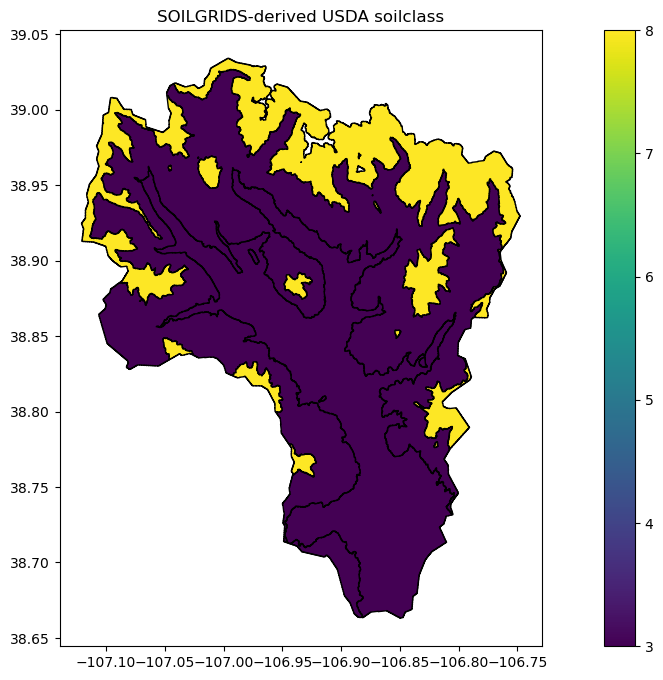

In [16]:
# Make a bplot to see what we did
shp.plot(column='soilTypeIndex',figsize=(16,8), legend=True,edgecolor='k')
ax = plt.gca()
ax.set_title('SOILGRIDS-derived USDA soilclass');

In [16]:
# Close the netCDF file
att.close()